In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import os
import json
import requests
from scipy.optimize import curve_fit
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)

In [3]:
covid_df = pd.read_csv(os.path.join("COVID","03-22-2020.csv"))
world_pop_df = pd.read_csv(os.path.join('GDP', 'world_countries_gdp.csv'))
median_age_df = pd.read_csv(os.path.join('Median Age', 'output','median_age.csv'))
life_expectancy = pd.read_csv(os.path.join('Life Expectancy','output','life_expectancy.csv'))
unemployment_rate = pd.read_csv(os.path.join('Unemployment Rate','output','unemployment_rate.csv'))
medical_expenditure = pd.read_csv(os.path.join("Medical Expenditure", "NHA indicators.csv"),encoding = 'ISO-8859-1')
poverty = pd.read_csv(os.path.join('Poverty','output','poverty.csv'))
literacy = pd.read_csv(os.path.join('Literacy_Rate','literacy_rate.csv'))
bed_density = pd.read_csv(os.path.join('Hospital_beds','beds_density.csv'))
gender_ratio = pd.read_csv(os.path.join('Gender Ratio','output','gender_ratio.csv'))

#number of countries in each csv

print(f"COVID-19 Countries: {covid_df['Country/Region'].nunique()}")
print(f"World Population Countries: {world_pop_df['country'].nunique()}")
print(f"Median Age Countries: {median_age_df['Country'].nunique()}")
print(f"Life Expectancy Countries: {life_expectancy['Country'].nunique()}")
print(f"Unemployment Rate Countries: {unemployment_rate['Country'].nunique()}")
print(f"Medical Expenditure Countries: {medical_expenditure['Countries'].nunique()}")
print(f"Poverty Countries: {poverty['Country'].nunique()}")
print(f"Literacy Countries: {literacy['Country'].nunique()}")
print(f"Bed Density Countries: {bed_density['Country'].nunique()}")
print(f"Gender Ratio Countries: {gender_ratio['Country'].nunique()}")

COVID-19 Countries: 183
World Population Countries: 218
Median Age Countries: 259
Life Expectancy Countries: 259
Unemployment Rate Countries: 259
Medical Expenditure Countries: 188
Poverty Countries: 259
Literacy Countries: 259
Bed Density Countries: 259
Gender Ratio Countries: 259


In [4]:
#get date only
#map takes in a function. So we use a temporary function (lambda)
covid_df['Last Update'] = covid_df['Last Update'].map(lambda x: x[0:10])

In [5]:
#clean data
aggregation_functions = {'Confirmed': 'sum',
                         'Deaths': 'sum',
                         'Recovered': 'sum',
                         'Latitude': 'first',
                         'Longitude': 'first'}
grouped_covid_df = covid_df.groupby(['Country/Region']).agg(aggregation_functions)

#grouped_covid_df.drop(['Latitude','Longitude'],1,inplace=True)
grouped_covid_df.rename(index = {"US":"United States","Taiwan*":"Taiwan"}, inplace=True)
grouped_covid_df.reset_index(inplace=True)
grouped_covid_df.rename(columns = {"Country/Region":"Country"}, inplace=True)
grouped_covid_df['Country'] = grouped_covid_df['Country'].replace({'The Bahamas':'Bahamas'})
grouped_covid_df['Country'] = grouped_covid_df['Country'].replace({'Bahamas, The':'Bahamas'})
medical_expenditure.columns = ['Countries', '2017 Health Budget per Capita ($)']
#grouped_covid_df.query('Country_Region.str.contains("Congo")',engine='python',inplace=True)

#clean medical expenditure
medical_expenditure.rename(columns = {'Countries': 'Country'},inplace=True)

In [6]:
#clean data
aggregation_functions = {'imfGDP': 'first',
                         'rank': 'first',
                         'unGDP': 'first',
                         'gdpPerCapita': 'first',
                         'pop': 'first'}

grouped_world_pop_df = world_pop_df.groupby('country').agg(aggregation_functions)
grouped_world_pop_df.drop(['rank','unGDP'],1,inplace=True)
grouped_world_pop_df.rename(index = {"South Korea":"Korea, South","Bahamas":"The Bahamas"}, 
                            columns = {"imfGDP": "GDP","gdpPerCapita": "GDP Per Capita","pop":"Population"},
                            inplace=True)
grouped_world_pop_df.index.name = 'Country'
grouped_world_pop_df.reset_index(inplace=True)

In [7]:
clean_median_age_df = median_age_df.copy()
clean_median_age_df['Country'] = clean_median_age_df['Country'].str.replace(pat='Bahamas, The',repl='The Bahamas',case=False)

clean_median_age_df.sort_values(by='Country',ascending=True,inplace=True)
clean_median_age_df.reset_index(drop=True,inplace=True)

In [8]:
merged_df = grouped_covid_df.merge(grouped_world_pop_df,how='outer',on='Country')
#merged_df.dropna(inplace=True)
merged_df.reset_index(drop=True,inplace=True)

In [9]:
complete_df = merged_df.merge(clean_median_age_df,how='outer',on='Country')
complete_df.sort_values(by='Country',ascending=True,inplace=True)
complete_df.reset_index(drop=True,inplace=True)
complete_df['Country'] = complete_df['Country'].replace({'The Bahamas':'Bahamas'})
#complete_df.dropna(inplace=True)
#complete_df.reset_index(drop=True,inplace=True)

complete_df.head()

,Country,Confirmed,Deaths,Recovered,Latitude,Longitude,GDP,GDP Per Capita,Population,Median Age
0,Afghanistan,40.0,1.0,1.0,33.9391,67.7100,2.068200e+10,531.2838,38928.346,19.0
1,Akrotiri,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,89.0,2.0,2.0,41.1533,20.1683,1.721000e+10,5980.2689,2877.797,33.4
3,Algeria,201.0,17.0,65.0,28.0339,1.6596,1.930560e+11,4402.5406,43851.044,28.3
4,American Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.1


In [10]:
#merge complete_df with bed_density
df_list = [bed_density,life_expectancy,unemployment_rate,medical_expenditure,poverty,literacy,gender_ratio]

for df in df_list:
    complete_df = complete_df.merge(df,how='outer',on='Country')

In [11]:
#fix this garbage data
complete_df['Country'] = complete_df['Country'].replace({'Congo':'Congo, Republic Of The'})
complete_df['Country'] = complete_df['Country'].replace({'Congo (Brazzaville)':'Congo, Republic Of The'})
complete_df['Country'] = complete_df['Country'].replace({'DR Congo':'Congo, Democratic Republic Of The'})
complete_df['Country'] = complete_df['Country'].replace({'Congo (Kinshasa)':'Congo, Democratic Republic Of The'})
complete_df['Country'] = complete_df['Country'].replace({'Democratic Republic of the Congo':'Congo, Democratic Republic Of The'})
complete_df['Country'] = complete_df['Country'].replace({'Republic of the Congo':'Congo, Democratic Republic Of The'})
complete_df['Country'] = complete_df['Country'].str.replace(pat='andorra',repl='Andorra',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat=' and ',repl=' And ',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='of ',repl='Of ',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='United States of America',repl='United States',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='the ',repl='The ',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='the ',repl='The ',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat=', The',repl='',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Bolivia Plurinational States Of',repl='Bolivia',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Brunei Darussalam',repl='Brunei',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Cabo Verde',repl='Cape Verde',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Cape Verde Republic of',repl='Cape Verde',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Cote D\'Ivoire',repl='Ivory Coast',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Cte d\'Ivoire',repl='Ivory Coast',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Cote d\'Ivoire',repl='Ivory Coast',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Cote d\'Ivoire',repl='Ivory Coast',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Cote d\'Ivoire',repl='Ivory Coast',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Lao People\'s Democratic Republic',repl='Laos',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Micronesia \(Federated States of\)',repl='Micronesia',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Micronesia, Federated States Of',repl='Micronesia',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Burma',repl='Myanmar',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='North Korea',repl='Korea, North',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Russian Federation',repl='Russia',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='North Macedonia',repl='Macedonia',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='The Republic Of Macedonia',repl='Macedonia',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Venezuela \(Bolivarian Republic of\)',repl='Venezuela',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Viet Nam',repl='Vietnam',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='United Republic Of Tanzania',repl='Tanzania',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Bolivia ',repl='Bolivia',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Republic Of Moldova',repl='Moldova',case=False)
complete_df['Country'] = complete_df['Country'].str.replace(pat='Republic Of Korea',repl='Korea, South',case=False)

In [12]:
#drop occupied Palestinian territory, holy see, oceans, and cruise
#complete_df.drop([287,114,115,11,16,35,121,193,240,66,283,297],axis=0,inplace=True)

#complete_df.query('Country.str.contains("Bolivia")',engine='python')

In [13]:
aggregation_functions = {'Latitude': 'first',
                         'Longitude': 'first',
                         'Confirmed': 'sum',
                         'Deaths': 'sum',
                         'Recovered': 'sum',
                         'GDP': 'sum',
                         'GDP Per Capita': 'sum',
                         'Population': 'sum',
                         'Median Age': 'sum',
                         'Hospital Bed Per 1000 Population Rate': 'sum',
                         'Life Expectancy (years)': 'sum',
                         'Unemployment Rate (%)': 'sum',
                         '2017 Health Budget per Capita ($)': 'sum',
                         'Poverty (% of Pop)': 'sum',
                         'Literacy Rate (% of Pop)': 'sum',
                         'Gender (% of male)': 'sum'}


complete_df.fillna(0,inplace=True)
#replace blanks and change datatype to float
complete_df['Hospital Bed Per 1000 Population Rate'] = complete_df['Hospital Bed Per 1000 Population Rate'].replace('',0)
complete_df['Literacy Rate (% of Pop)'] = complete_df['Literacy Rate (% of Pop)'].replace('',0)
complete_df['2017 Health Budget per Capita ($)'] = complete_df['2017 Health Budget per Capita ($)'].replace('-',0)
complete_df['2017 Health Budget per Capita ($)'] = complete_df['2017 Health Budget per Capita ($)'].astype('float64')
complete_df.head()

,Country,Confirmed,Deaths,Recovered,Latitude,Longitude,GDP,GDP Per Capita,Population,Median Age,Hospital Bed Per 1000 Population Rate,Life Expectancy (years),Unemployment Rate (%),2017 Health Budget per Capita ($),Poverty (% of Pop),Literacy Rate (% of Pop),Gender (% of male)
0,Afghanistan,40.0,1.0,1.0,33.9391,67.7100,2.068200e+10,531.2838,38928.346,19.0,0.5,52.1,23.9,67.0,54.5,38.2,50.7389
1,Akrotiri,0.0,0.0,0.0,0.0000,0.0000,0.000000e+00,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
2,Albania,89.0,2.0,2.0,41.1533,20.1683,1.721000e+10,5980.2689,2877.797,33.4,2.9,78.6,13.8,0.0,14.3,97.6,49.4949
3,Algeria,201.0,17.0,65.0,28.0339,1.6596,1.930560e+11,4402.5406,43851.044,28.3,1.9,77.2,11.7,258.0,23.0,80.2,50.7389
4,American Samoa,0.0,0.0,0.0,0.0000,0.0000,0.000000e+00,0.0000,0.000,26.1,0.0,73.9,29.8,0.0,0.0,0.0,50.0000


In [14]:
#191,Andorra,‭0‬,2858406626,36994.8441,77.265
complete_df['GDP'] = complete_df['GDP'].astype('float64')
complete_df = complete_df.groupby('Country').aggregate(aggregation_functions)

In [15]:

complete_df['Population'] = (complete_df['Population'] * 1000).astype('int64')
complete_df.query('Country.str.contains("Bahama")',engine='python')

,Latitude,Longitude,Confirmed,Deaths,Recovered,GDP,GDP Per Capita,Population,Median Age,Hospital Bed Per 1000 Population Rate,Life Expectancy (years),Unemployment Rate (%),2017 Health Budget per Capita ($),Poverty (% of Pop),Literacy Rate (% of Pop),Gender (% of male)
Country,,,,,,,,,,,,,,,,
Bahamas,24.25,-76.0,4.0,0.0,0.0,1.371000e+10,34863.8504,393244,32.3,2.9,72.9,10.1,5316.0,9.3,0.0,48.9796


In [16]:
complete_df.drop(['Holy See',
                  'Holy See (Vatican City)',
                  'Atlantic Ocean',
                  'Arctic Ocean',
                  'British Indian Ocean Territory',
                 'Indian Ocean',
                 'Pacific Ocean',
                 'Southern Ocean',
                 'Cruise Ship',
                 'World',
                 'European Union'],axis=0,inplace=True)

In [17]:
complete_df = complete_df[(complete_df.T != 0).any()]

In [18]:
complete_df.to_csv(os.path.join('Final Data','complete_data.csv'), index=True)

In [19]:
confirmed_df = complete_df.loc[complete_df["Confirmed"] > 0]
confirmed_df["Mortality Rate (%)"] = round((confirmed_df["Deaths"]/confirmed_df["Confirmed"])*100,2)
confirmed_df["Confirmed Per 100000"] = (confirmed_df["Confirmed"]/confirmed_df["Population"])*100000

confirmed_df.sort_values('Confirmed Per 100000')
#confirmed_df

,Latitude,Longitude,Confirmed,Deaths,Recovered,GDP,GDP Per Capita,Population,Median Age,Hospital Bed Per 1000 Population Rate,Life Expectancy (years),Unemployment Rate (%),2017 Health Budget per Capita ($),Poverty (% of Pop),Literacy Rate (% of Pop),Gender (% of male),Mortality Rate (%),Confirmed Per 100000
Country,,,,,,,,,,,,,,,,,,
Uganda,1.3733,32.2903,1.0,0.0,0.0,3.362000e+10,735.0079,45741007,15.9,0.5,56.30,9.4,39.0,21.4,78.4,49.7487,0.00,0.002186
Mozambique,-18.6657,35.5296,1.0,0.0,0.0,1.629400e+10,521.3173,31255435,17.3,0.7,54.10,24.5,21.0,46.1,56.0,48.9796,0.00,0.003199
Sudan,12.8628,30.2176,2.0,1.0,0.0,0.000000e+00,1890.2804,43849260,17.9,0.8,65.80,19.6,194.0,46.5,75.9,50.2488,50.00,0.004561
Syria,34.8021,38.9968,1.0,0.0,0.0,0.000000e+00,1266.4138,17500658,24.5,1.5,75.20,50.0,0.0,82.5,86.4,50.2488,0.00,0.005714
Angola,-11.2027,17.8739,2.0,0.0,0.0,9.642600e+10,2933.8892,32866272,15.9,0.0,60.60,6.6,114.0,36.6,71.1,48.7179,0.00,0.006085
Chad,15.4542,18.7322,1.0,0.0,0.0,1.254700e+10,763.8563,16425863,15.8,0.0,57.50,0.0,30.0,46.7,22.3,49.4949,0.00,0.006088
Somalia,5.1521,46.1996,1.0,0.0,0.0,8.341000e+09,524.8149,15893222,18.2,8.7,53.20,0.0,0.0,0.0,0.0,50.2488,0.00,0.006292
Nepal,28.3949,84.1240,2.0,0.0,1.0,3.303500e+10,1133.7893,29136807,24.5,3.0,71.30,3.0,48.0,25.2,63.9,48.9796,0.00,0.006864
Niger,17.6078,8.0817,2.0,0.0,0.0,1.062800e+10,439.0530,24206644,15.5,0.0,56.30,0.3,29.0,45.4,19.1,50.2488,0.00,0.008262


The r-squared is: 0.3087284172719639
The p-value is: 1.1562097909213798e-07


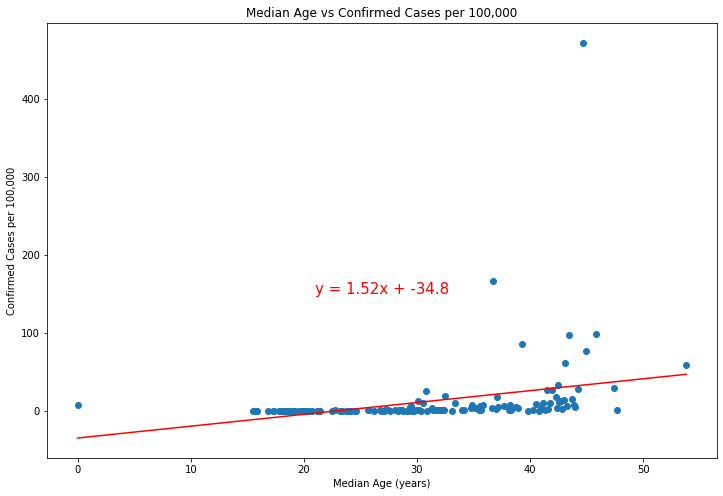

In [54]:
plt.figure(figsize=(12,8))

med_age = confirmed_df.groupby("Median Age")

confirmed_per100000 = med_age["Confirmed Per 100000"].mean()

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(confirmed_per100000.index, confirmed_per100000.values)
regress_values = confirmed_per100000.index * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(confirmed_per100000.index, confirmed_per100000.values)
plt.plot(confirmed_per100000.index,regress_values,"r-")
plt.annotate(line_eq,(21,150),fontsize=15,color="red")

plt.title("Median Age vs Confirmed Cases per 100,000")

plt.xlabel("Median Age (years)")
plt.ylabel("Confirmed Cases per 100,000")

print(f"The r-squared is: {rvalue}")
#calc pvalue
pvalue = stats.ttest_ind(confirmed_df['Median Age'], confirmed_df["Confirmed Per 100000"],equal_var=False)[1]
print(f'The p-value is: {pvalue}')

plt.show()

The r-squared is: -0.03152110809866011
The p-value is: 4.234117673933381e-90


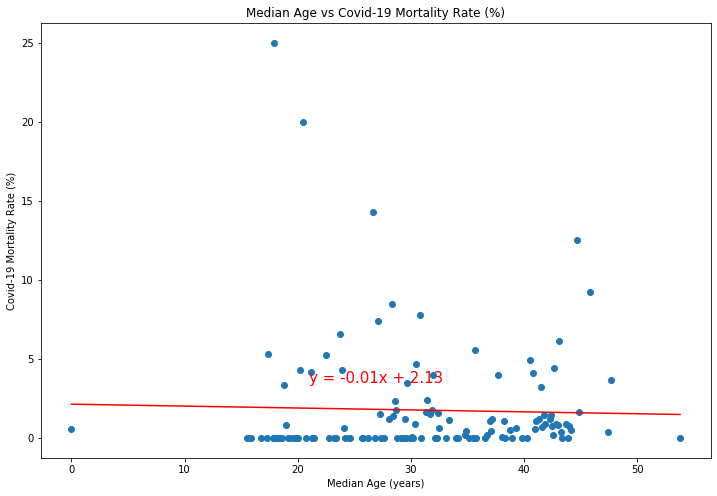

In [61]:
plt.figure(figsize=(12,8))

med_age = confirmed_df.groupby("Median Age")

mean_mortality = med_age["Mortality Rate (%)"].mean()

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(mean_mortality.index, mean_mortality.values)
regress_values = mean_mortality.index * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(mean_mortality.index, mean_mortality.values)
plt.plot(mean_mortality.index,regress_values,"r-")
plt.annotate(line_eq,(21,3.5),fontsize=15,color="red")

plt.title("Median Age vs Covid-19 Mortality Rate (%)")

plt.xlabel("Median Age (years)")
plt.ylabel("Covid-19 Mortality Rate (%)")

print(f"The r-squared is: {rvalue}")
#return random 25% and ttest that data
#calc pvalue
pvalue = stats.ttest_ind(confirmed_df["Median Age"], confirmed_df["Mortality Rate (%)"],equal_var=False)[1]
print(f'The p-value is: {pvalue}')

plt.show()

The r-squared is: -0.15180649015253606
The p-value is: 0.006498885123742215


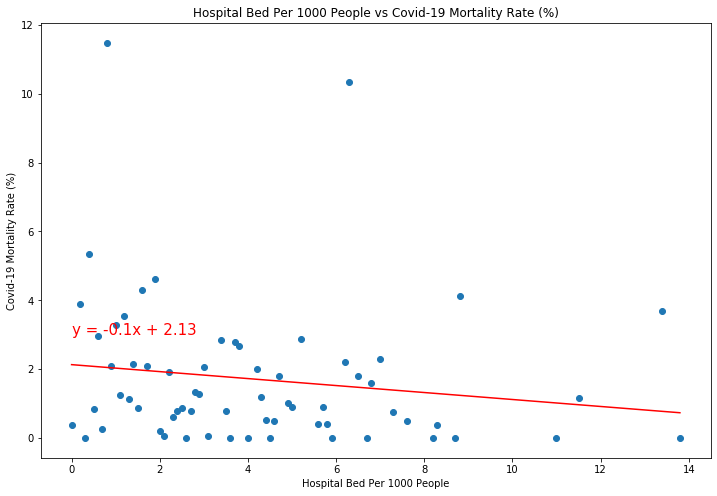

In [64]:
plt.figure(figsize=(12,8))

hospital_bed = confirmed_df.groupby("Hospital Bed Per 1000 Population Rate")

mean_mortality = hospital_bed["Mortality Rate (%)"].mean()

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(mean_mortality.index, mean_mortality.values)
regress_values = mean_mortality.index * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(mean_mortality.index, mean_mortality.values)
plt.plot(mean_mortality.index,regress_values,"r-")
plt.annotate(line_eq,(0,3),fontsize=15,color="red")

plt.title("Hospital Bed Per 1000 People vs Covid-19 Mortality Rate (%)")

plt.xlabel("Hospital Bed Per 1000 People")
plt.ylabel("Covid-19 Mortality Rate (%)")

print(f"The r-squared is: {rvalue}")
#calc pvalue
pvalue = stats.ttest_ind(confirmed_df["Hospital Bed Per 1000 Population Rate"], confirmed_df["Mortality Rate (%)"],equal_var=False)[1]
print(f'The p-value is: {pvalue}')

plt.show()

The r-squared is: -0.038416557714507533
The p-value is: 3.6763508218450707e-13


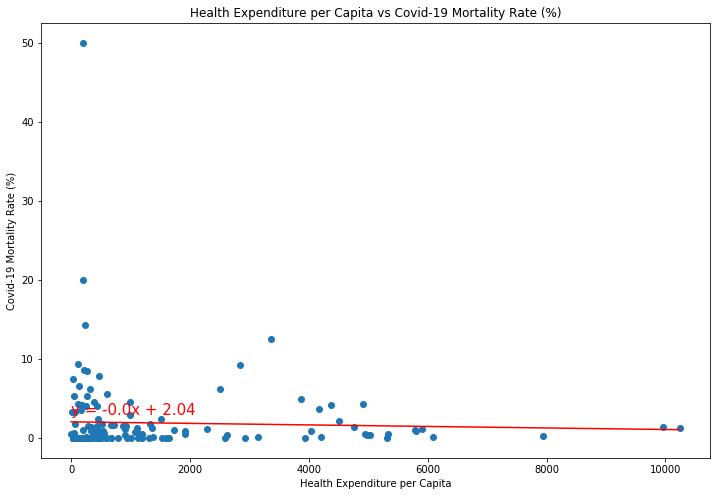

In [65]:
plt.figure(figsize=(12,8))

health_exp = confirmed_df.groupby("2017 Health Budget per Capita ($)")

mean_mortality = health_exp["Mortality Rate (%)"].mean()

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(mean_mortality.index, mean_mortality.values)
regress_values = mean_mortality.index * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(mean_mortality.index, mean_mortality.values)
plt.plot(mean_mortality.index,regress_values,"r-")
plt.annotate(line_eq,(0,3),fontsize=15,color="red")

plt.title("Health Expenditure per Capita vs Covid-19 Mortality Rate (%)")

plt.xlabel("Health Expenditure per Capita")
plt.ylabel("Covid-19 Mortality Rate (%)")

print(f"The r-squared is: {rvalue}")
#calc pvalue
pvalue = stats.ttest_ind(confirmed_df["2017 Health Budget per Capita ($)"], confirmed_df["Mortality Rate (%)"],equal_var=False)[1]
print(f'The p-value is: {pvalue}')

plt.show()

In [66]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

#Define the data to be fit with some noise:

xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
np.random.seed(1729)
y_noise = 0.2 * np.random.normal(size=xdata.size)
ydata = y + y_noise
plt.plot(xdata, ydata, 'b-', label='data')

#Fit for the parameters a, b, c of the function func:

popt, pcov = curve_fit(func, xdata, ydata)
popt

plt.plot(xdata, func(xdata, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

#Constrain the optimization to the region of 0 <= a <= 3, 0 <= b <= 1 and 0 <= c <= 0.5:

popt, pcov = curve_fit(func, xdata, ydata, bounds=(0, [3., 1., 0.5]))
popt

plt.plot(xdata, func(xdata, *popt), 'g--',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))


plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()



NameError: name 'np' is not defined